# Chapter 3. Geocentric Models

In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from quap import quap
import seaborn as sns


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format = 'retina'

## 3.3. Multiple estimands and categories

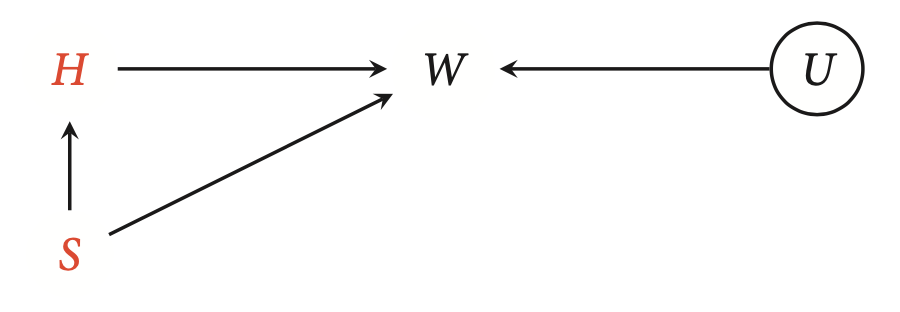

#### Code 3.34

In [3]:
from scipy.stats import norm

def sim_HW(S, b, a):
    """
    Simulate height and weight as function of sex.
    S=0 female; S=1 male
    """
    a, b = np.array(a), np.array(b)
    N = len(S)
    H = np.where(S==0,150,160) + norm(0,5).rvs(N)
    W = a[S] + b[S]*H + norm(0,5).rvs(N)
    return pd.DataFrame({"S":S, "H":H, "W":W})

#### Code 3.35

In [4]:
np.random.seed(42)

# random sex at birth assignments
from scipy.stats import bernoulli
S = bernoulli(p=0.5).rvs(100)

# simulate with small difference in b for sexes
dat = sim_HW(S, b=[0.5,0.6], a=[0,0])
dat.head()

,S,H,W
0,0,150.435235,75.282627
1,1,158.504963,102.370648
2,1,160.458804,94.951998
3,1,150.062155,103.638139
4,0,148.901641,77.579157


In [5]:
# dat.groupby("S").describe()

### 3.3.2. Estimand: Total influence of sex on weight

#### Code 3.36

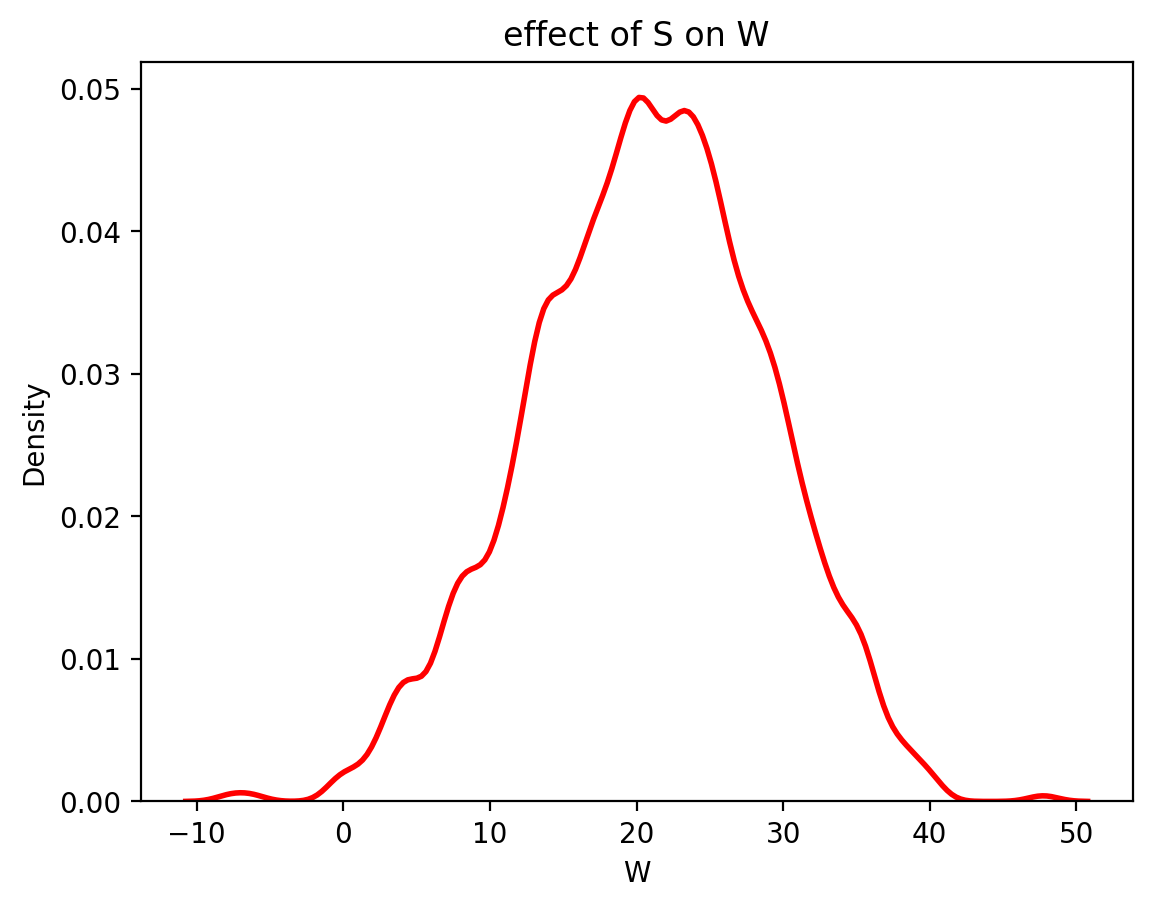

In [6]:
N = 1000
np.random.seed(43)

# female sample
S = np.zeros(N, dtype=int)
simF = sim_HW(S, b=[0.5,0.6], a=[0,0])

# male sample
S = np.ones(N, dtype=int)
simM = sim_HW(S, b=[0.5,0.6], a=[0,0])

# effect of sex (male-female)
ax = sns.kdeplot(x=simM["W"] - simF["W"], bw_adjust=0.5, c="r", lw=2)
ax.set_title("effect of S on W");

#### Code 3.37

In [7]:
np.random.seed(48)

# observe sample
S = bernoulli(p=0.5).rvs(100)
dat = sim_HW(S, b=[0.5,0.6], a=[0,0])

# estimate posterior
with pm.Model() as m_SW:
    S = pm.MutableData("S", dat["S"].values)
    a = pm.Normal("a", 60, 10, shape=2)
    sigma = pm.Uniform("sigma", 0, 10)
    mu = a[S]
    W = pm.Normal("W", mu, sigma, observed=dat["W"].values, shape=dat["S"].shape)
    trace_m_SW_sim = quap([a, sigma])

az.summary(trace_m_SW_sim, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
a[0],74.82,0.84,73.23,76.41
a[1],95.89,0.97,94.18,97.79
sigma,6.38,0.45,5.58,7.26


In [8]:
# MCMC result (for comparison)
#         mean 	   sd   hdi_3%  hdi_97%
# a[0] 	74.836 	0.880 	73.132 	76.457
# a[1] 	95.875 	1.019 	93.940 	97.755
# sigma  6.538 	0.490 	 5.723 	 7.500

#### Code 3.38

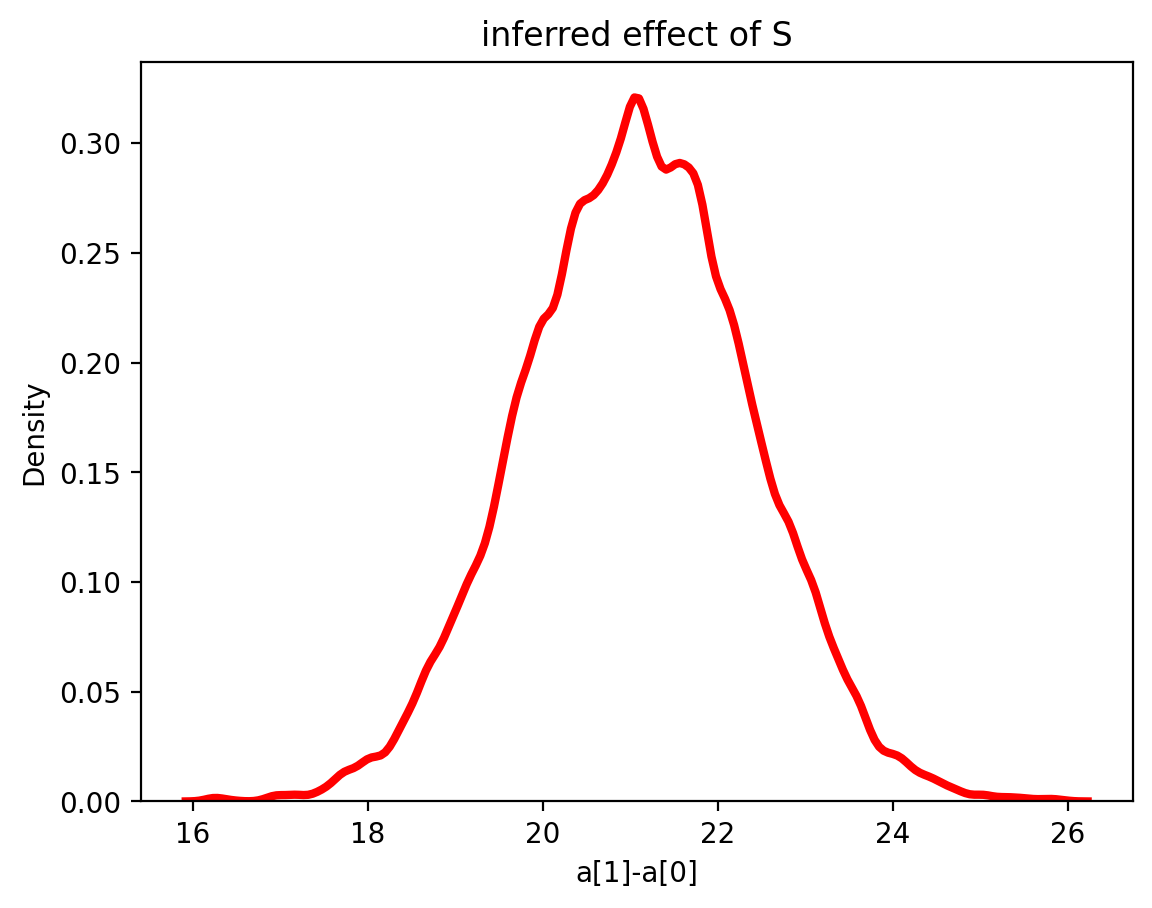

In [9]:
post = az.extract(trace_m_SW_sim, group="posterior")
ax = sns.kdeplot(x=post["a"][1]-post["a"][0], bw_adjust=0.5, c="r", lw=3)
ax.set_title("inferred effect of S")
ax.set_xlabel("a[1]-a[0]");

#### Code 3.39

In [10]:
# prep data
Howell1 = pd.read_csv("Data/Howell1.csv", sep=";")
d = Howell1[ Howell1["age"]>=18 ]
dat = pd.DataFrame({"W":d["weight"],
                    "S":d["male"]})  # S=0 female, S=1 male

# same estimator as before
with pm.Model() as m_SW:
    S = pm.MutableData("S", dat["S"].values)
    a = pm.Normal("a", 60, 10, shape=2)
    sigma = pm.Uniform("sigma", 0, 10)
    mu = a[S]
    W = pm.Normal("W", mu, sigma, observed=dat["W"].values, shape=dat["S"].shape)
    trace_m_SW_real = quap([a, sigma])

az.summary(trace_m_SW_real, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
a[0],41.85,0.40,41.10,42.61
a[1],48.61,0.42,47.83,49.42
sigma,5.49,0.21,5.09,5.88


#### Code 3.40

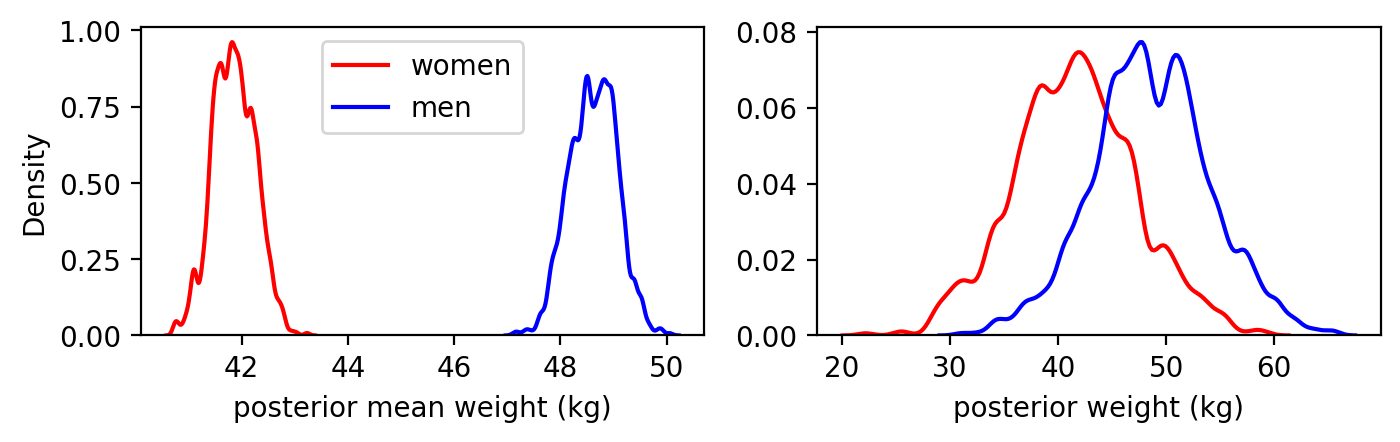

In [11]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,2))

# posterior mean W
post = az.extract(trace_m_SW_real, num_samples=1000)
sns.kdeplot(x=post["a"][0], ax=ax1, bw_adjust=0.5, c="r")
sns.kdeplot(x=post["a"][1], ax=ax1, bw_adjust=0.5, c="b")
ax1.set_xlabel("posterior mean weight (kg)")
ax1.legend(["women","men"], loc="upper center")

# posterior W distributions
W0 = norm(post["a"][0], post["sigma"] ).rvs(1000)
W1 = norm(post["a"][1], post["sigma"] ).rvs(1000)
sns.kdeplot(x=W0, ax=ax2, bw_adjust=0.5, c="r")
sns.kdeplot(x=W1, ax=ax2, bw_adjust=0.5, c="b")
ax2.set_xlabel("posterior weight (kg)")
ax2.set_ylabel(None);

#### Code 3.41

0.807

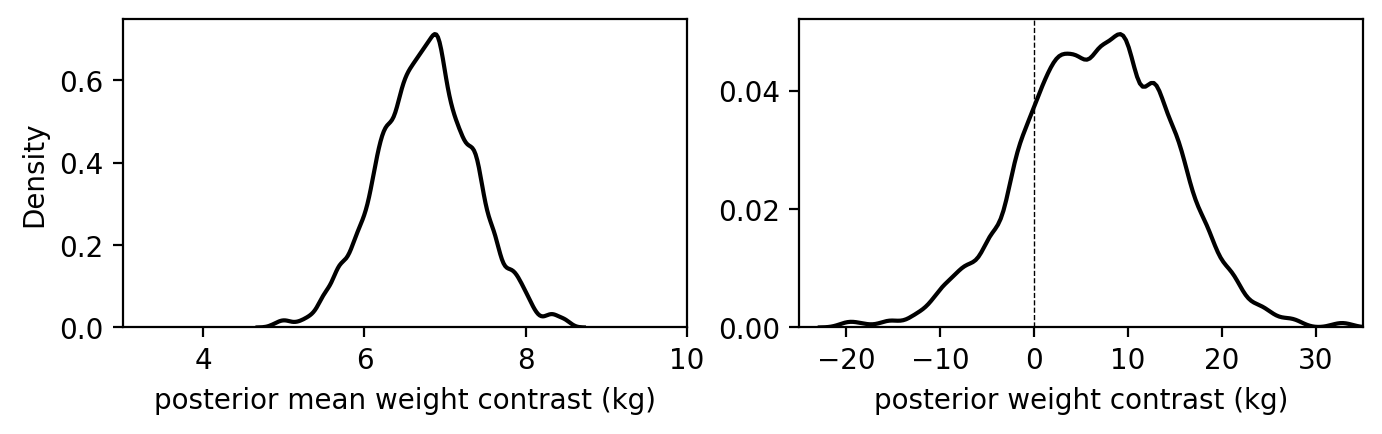

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2,  figsize=(8,2))

# causal contrast (in means)
mu_contrast = post["a"][1] - post["a"][0]
sns.kdeplot(x=mu_contrast, ax=ax1, bw_adjust=0.5, c="k")
ax1.set_xlabel("posterior mean weight contrast (kg)")
ax1.set_xlim([3,10])

# posterior W distributions
W0 = norm(post["a"][0], post["sigma"]).rvs(1000)
W1 = norm(post["a"][1], post["sigma"]).rvs(1000)

# contrast
W_contrast = W1 - W0
sns.kdeplot(x=W_contrast, ax=ax2, bw_adjust=0.5, c="k")
ax2.set_xlabel("posterior weight contrast (kg)")
ax2.axvline(0, c="k", ls="--", lw=0.5)
ax2.set_ylabel(None)
ax2.set_xlim([-25,35])

# proportion above zero
sum( W_contrast > 0 ) / 1000

### 3.3.3. Estimand: Direct influence of sex on weight

#### Code 3.42

Text(0, 0.5, 'weight (kg)')

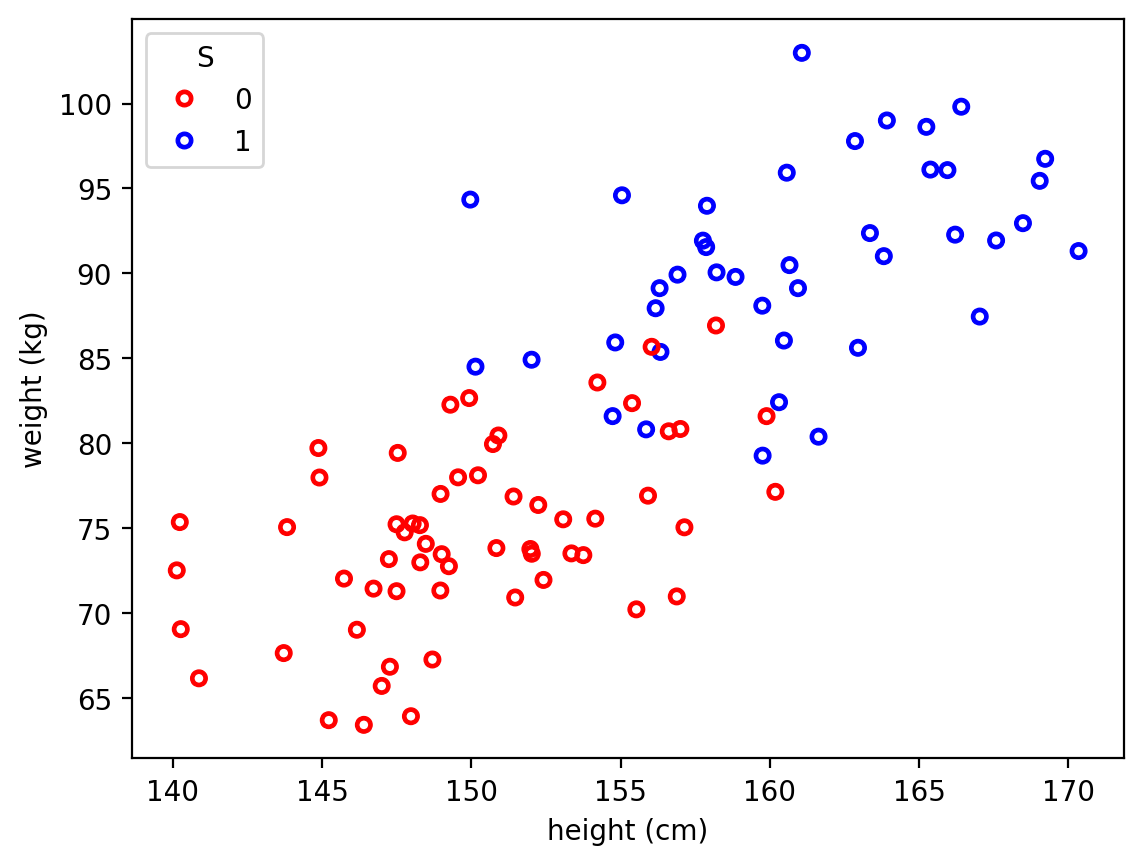

In [13]:
np.random.seed(46)

S = bernoulli(p=0.5).rvs(100)
dat = sim_HW(S, b=[0.5,0.5], a=[0,10])
ax = sns.scatterplot(data=dat, x="H", y="W", hue="S",
                     marker="$\circ$", ec="face", palette=["r","b"])
ax.set_xlabel("height (cm)")
ax.set_ylabel("weight (kg)")

#### Code 3.43

In [14]:
# prep data
Howell1 = pd.read_csv("Data/Howell1.csv", sep=";")
d = Howell1[ Howell1["age"]>=18 ]
dat = pd.DataFrame({"W":d["weight"],
                    "H":d["height"],
                    "S":d["male"]})  # S=0 female, S=1 male
Hbar = dat["H"].mean()

with pm.Model() as m_SHW:
    S = pm.MutableData("S", dat["S"].values)
    H = pm.MutableData("H", dat["H"].values)
    a = pm.Normal("a", 60, 10, shape=2)
    b = pm.Uniform("b", 0, 1, shape=2)
    sigma = pm.Uniform("sigma", 0, 10)
    mu = a[S] + b[S]*(H-Hbar)
    W = pm.Normal("W", mu, sigma, observed=dat["W"].values, shape=dat["S"].shape)
    trace_m_SHW_real = quap([a, b, sigma])

#### Code 3.44

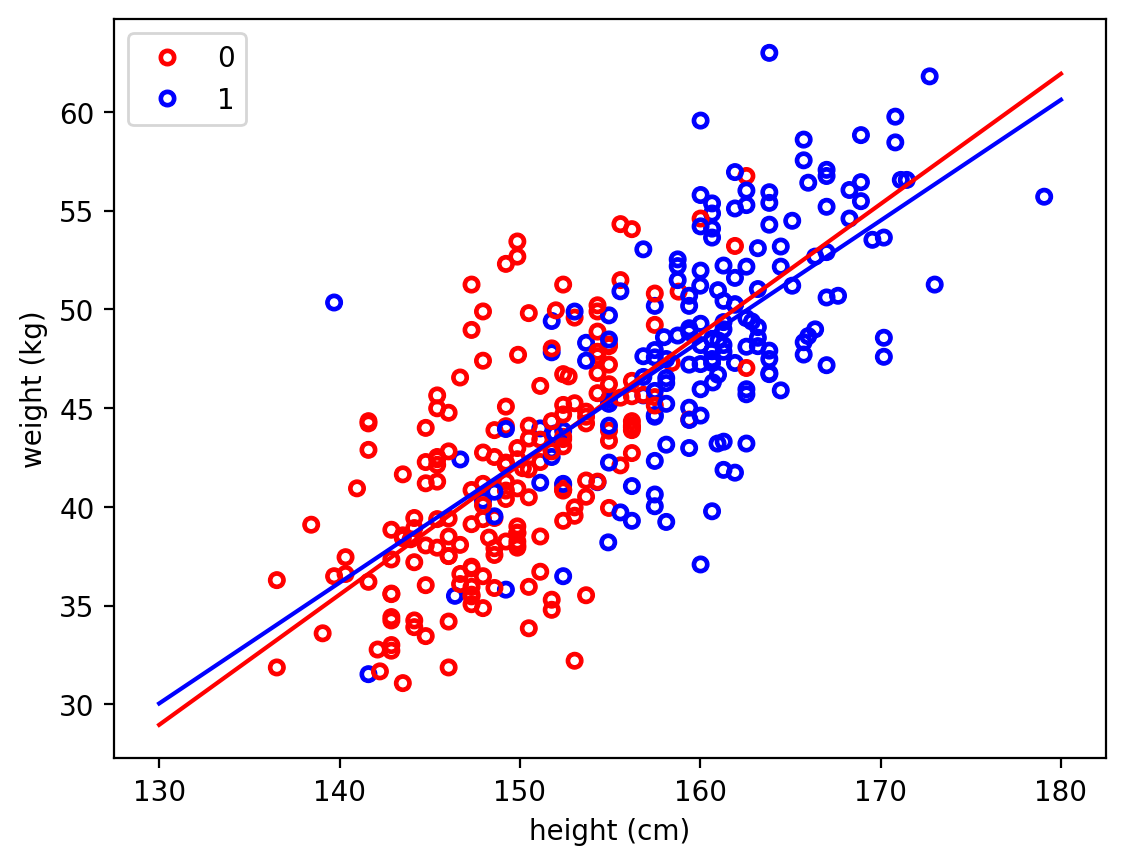

In [15]:
# plot data
ax = sns.scatterplot(data=dat, x="H", y="W", hue="S",
                     marker="$\circ$", ec="face", palette=["r","b"])
ax.set_xlabel("height (cm)")
ax.set_ylabel("weight (kg)")

# extract means from posterior
post = az.extract(trace_m_SHW_real)
meana = post["a"].values.mean(axis=1)
meanb = post["b"].values.mean(axis=1)

# posterior lines
Hseq = np.linspace(130, 180, num=30)
W0 = meana[0] + meanb[0]*(Hseq-Hbar)
W1 = meana[1] + meanb[1]*(Hseq-Hbar)
sns.lineplot(x=Hseq, y=W0, color='r', ax=ax)
sns.lineplot(x=Hseq, y=W1, color='b', ax=ax);

### 3.4.1. Polynomial regression

#### Code 3.45

#### Code 3.46